# Visualization of a Simple Stochastic Gradient Descent

Here we visualize the minimization of the loss with the SGD algorithm in its variants vanilla GD, batch SGD and minibatch SGD.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import socket
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils import data

from tqdm.notebook import trange, tqdm

from line_regression import get_curve_data, plot_loss

In [2]:
torch.__version__

'1.9.0+cu111'

## Dataset

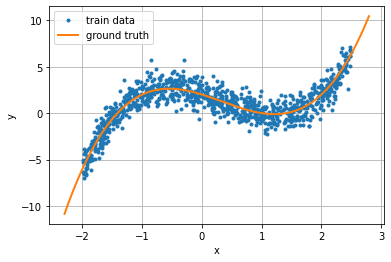

In [3]:
# Create a linear function with noise as our data
nsamples = 1000
x_train, y_train, ground_truth = get_curve_data(nsamples)

plt.plot(x_train, y_train, '.', label='train data')
plt.plot(*ground_truth, '-', linewidth=2, label='ground truth')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()
plt.show()

## Input pipeline

In [4]:
# CPU/GPU Tensors
device = 'cpu' #'cuda'
x = torch.tensor(x_train, dtype=torch.float32, device=device)
y = torch.tensor(y_train, dtype=torch.float32, device=device)
gt = torch.tensor(ground_truth, dtype=torch.float32, device=device)

In [5]:
# Initialize multilayer perceptron with dimenssionality N
n_features = 4

model = nn.Sequential(OrderedDict([
    ('hiddenlayer', nn.Linear(1, n_features, bias=True)),
    ('activation', nn.ReLU()),
    ('regressor', nn.Linear(n_features, 1, bias=True)),
]))

print(model)
dict(model.named_parameters())

Sequential(
  (hiddenlayer): Linear(in_features=1, out_features=4, bias=True)
  (activation): ReLU()
  (regressor): Linear(in_features=4, out_features=1, bias=True)
)


{'hiddenlayer.weight': Parameter containing:
 tensor([[ 0.2991],
         [ 0.4210],
         [ 0.0660],
         [-0.6243]], requires_grad=True),
 'hiddenlayer.bias': Parameter containing:
 tensor([ 0.5796, -0.9959, -0.7713, -0.4560], requires_grad=True),
 'regressor.weight': Parameter containing:
 tensor([[-0.2312,  0.1432, -0.4234, -0.2027]], requires_grad=True),
 'regressor.bias': Parameter containing:
 tensor([-0.3997], requires_grad=True)}

In [6]:
# Store initial predictions
with torch.no_grad():
    y_init = model(gt[0].unsqueeze(-1))

In [7]:
epochs = 1000
history = []
batch_size = 1000
lr = 0.0005 * batch_size**0.5

# dataset = torch.cat([x, y], dim=1)
dataset = data.TensorDataset(x, y)
loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)
# model.train()

pbar = trange(epochs, position=0, desc='Epochs')
for e in pbar:
    for i, batch in enumerate(loader):
        data, target = batch

        # Calculate loss
        y_hat = model(data)
        mse = F.mse_loss(y_hat, target)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Calculate gradients
        mse.backward()
        # Training step
        optimizer.step()

        history.append(mse.item())
        pbar.set_description(f'MSE={mse.item():0.03f} ')
        
# plot_regression(history, x_train, y_train, ground_truth)
{n:p.tolist() for n,p in model.named_parameters()}

Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

{'hiddenlayer.weight': [[-0.8954654932022095],
  [1.9150289297103882],
  [0.06600093841552734],
  [-2.6768860816955566]],
 'hiddenlayer.bias': [0.9734658002853394,
  -3.2597556114196777,
  -0.7712762355804443,
  -2.5965328216552734],
 'regressor.weight': [[1.7428640127182007,
   3.686607599258423,
   -0.42340147495269775,
   -3.585869789123535]],
 'regressor.bias': [0.012214736081659794]}

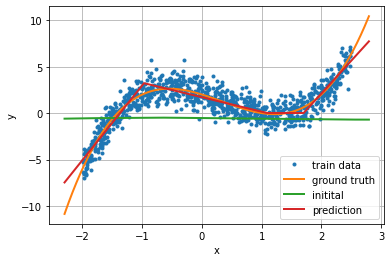

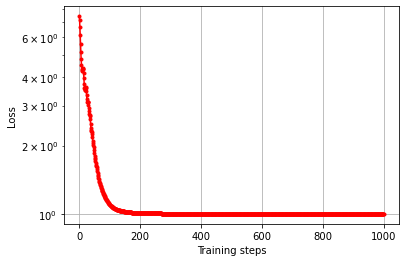

In [8]:
# model.eval()
with torch.no_grad():
    y_hat = model(gt[0].unsqueeze(-1))

plt.plot(x_train, y_train, '.', label='train data')
plt.plot(*ground_truth, '-', linewidth=2, label='ground truth')
plt.plot(ground_truth[0], y_init.tolist(), '-', linewidth=2, label='initital')
plt.plot(ground_truth[0], y_hat.tolist(), '-', linewidth=2, label='prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()

plot_loss(np.array(history))

plt.show()

<mark>Exercise 2</mark>: 
1. Try different activation functions or model sizes (hidden layer dimensions)
2. Can the batch size affect the convergence?

<br><br>

# Distributed Example

In [9]:
import ipcmagic
%ipcluster start -n 2 --mpi

  0%|          | 0/2 [00:00<?, ?engine/s]

In [10]:
%%px
import os
import sys
import socket
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
from torch import nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.utils import data

from tqdm.std import trange, tqdm

from line_regression import get_curve_data, plot_loss

# Setup environment for torch.distributed.init_process_group
os.environ['MASTER_PORT'] = '29500'
os.environ['WORLD_SIZE'] = os.environ['SLURM_NNODES']
os.environ['LOCAL_RANK'] = '0'
os.environ['RANK'] = os.environ['SLURM_NODEID']

world_size = int(os.environ['SLURM_NNODES'])
rank = int(os.environ['SLURM_NODEID'])

print(socket.gethostname(), rank, world_size)

[stdout:0] nid07206 0 2
[stdout:1] nid07207 1 2


In [11]:
master_address = f"'{socket.gethostbyname(socket.gethostname())}'"
%px os.environ['MASTER_ADDR'] = $master_address
%px print(os.environ['MASTER_ADDR'])

[stdout:1] 148.187.60.95
[stdout:0] 148.187.60.95


In [12]:
%%px
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP

if not dist.is_initialized():
    # Environment variable initialization
    dist.init_process_group(backend="nccl")

nsamples = 1000
x_train, y_train, ground_truth = get_curve_data(nsamples)

# GPU Tensors
device = 'cuda'
x = torch.tensor(x_train, dtype=torch.float32, device=device)
y = torch.tensor(y_train, dtype=torch.float32, device=device)
gt = torch.tensor(ground_truth, dtype=torch.float32, device=device)

n_features = 32
model = nn.Sequential(OrderedDict([
    ('hiddenlayer', nn.Linear(1, n_features, bias=True)),
    ('activation', nn.SiLU()),
    ('regressor', nn.Linear(n_features, 1, bias=True)),
]))

### Task 1: move the model to GPU and wrap it with DistributedDataParallel
dist_model = DDP(model.to(device))

[stdout:0] 
nid07206:28565:28565 [0] NCCL INFO Bootstrap : Using [0]ipogif0:148.187.60.95<0>
nid07206:28565:28565 [0] NCCL INFO NET/Plugin : No plugin found (libnccl-net.so), using internal implementation
nid07206:28565:28565 [0] NCCL INFO NET/IB : No device found.
nid07206:28565:28565 [0] NCCL INFO NET/Socket : Using [0]ipogif0:148.187.60.95<0>
nid07206:28565:28565 [0] NCCL INFO Using network Socket
NCCL version 2.7.8+cuda11.1


[stderr:0] 
libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/22.3-7.0.2.1_2.72__g42f5f32b.ari/etc/libibverbs.d'.


[stdout:0] 
nid07206:28565:28601 [0] NCCL INFO Channel 00/02 :    0   1
nid07206:28565:28601 [0] NCCL INFO Channel 01/02 :    0   1
nid07206:28565:28601 [0] NCCL INFO threadThresholds 8/8/64 | 16/8/64 | 8/8/64
nid07206:28565:28601 [0] NCCL INFO Trees [0] 1/-1/-1->0->-1|-1->0->1/-1/-1 [1] -1/-1/-1->0->1|1->0->-1/-1/-1
nid07206:28565:28601 [0] NCCL INFO Setting affinity for GPU 0 to ffffff
nid07206:28565:28601 [0] NCCL INFO Channel 00 : 1[2000] -> 0[2000] [receive] via NET/Socket/0
nid07206:28565:28601 [0] NCCL INFO Channel 00 : 0[2000] -> 1[2000] [send] via NET/Socket/0
nid07206:28565:28601 [0] NCCL INFO Channel 01 : 1[2000] -> 0[2000] [receive] via NET/Socket/0
nid07206:28565:28601 [0] NCCL INFO Channel 01 : 0[2000] -> 1[2000] [send] via NET/Socket/0
nid07206:28565:28601 [0] NCCL INFO 2 coll channels, 2 p2p channels, 1 p2p channels per peer
nid07206:28565:28601 [0] NCCL INFO comm 0x2aac24002dc0 rank 0 nranks 2 cudaDev 0 busId 2000 - Init COMPLETE
nid07206:28565:28565 [0] NCCL INFO Laun

[stderr:1] 
libibverbs: Could not locate libibgni (/usr/lib64/libibgni.so.1: undefined symbol: verbs_uninit_context)
libibverbs: Warning: couldn't open config directory '/opt/cray/rdma-core/22.3-7.0.2.1_2.72__g42f5f32b.ari/etc/libibverbs.d'.


In [13]:
%%px
# Store initial predictions
with torch.no_grad():
    y_init = model(gt[0].unsqueeze(-1))

history = []

In [14]:
%%px --noblock -o training
epochs = 1000
batch_size = 100
lr = 0.0005 * batch_size**0.5

dataset = data.TensorDataset(x, y)

### Task 2: Setup the DistributedSampler
### https://pytorch.org/docs/stable/data.html#torch.utils.data.distributed.DistributedSampler
### to load a subset of the original dataset that is exclusive to each rank
sampler = data.distributed.DistributedSampler(dataset, rank=dist.get_rank())
loader = data.DataLoader(dataset, batch_size=batch_size, sampler=sampler)

optimizer = torch.optim.SGD(model.parameters(), lr, momentum=0.9)

pbar = trange(epochs, file=sys.__stdout__)
for epoch in pbar:
    sampler.set_epoch(epoch)
    for i, batch in enumerate(loader):
        data, target = batch

        # Calculate loss
        y_hat = dist_model(data)
        mse = F.mse_loss(y_hat, target)

        # Zero the parameter gradients
        optimizer.zero_grad()
        # Calculate gradients
        mse.backward()
        # Training step
        optimizer.step()

        history.append(mse.item())
    pbar.set_description(f'MSE={mse.item():0.03f} ')

<AsyncResult: execute>

In [15]:
# watch the output in real time
from ipcmagic import utilities
utilities.watch_asyncresult(training)

[ stdout 0 ]
MSE=1.022 : 100%|██████████| 1000/1000 [00:16<00:00, 62.06it/s]
[ stdout 1 ]
MSE=0.831 : 100%|██████████| 1000/1000 [00:16<00:00, 62.06it/s]


[output:0]

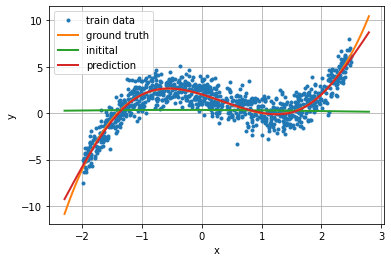

[output:0]

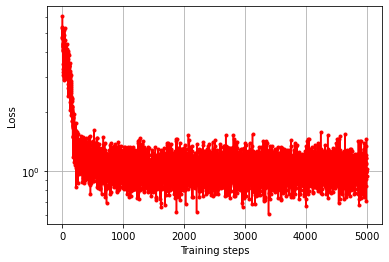

Out[0:7]: 0

In [16]:
%%px --targets 0

# model.eval()
with torch.no_grad():
    y_hat = model(gt[0].unsqueeze(-1))

plt.plot(x_train, y_train, '.', label='train data')
plt.plot(*ground_truth, '-', linewidth=2, label='ground truth')
plt.plot(ground_truth[0], y_init.tolist(), '-', linewidth=2, label='initital')
plt.plot(ground_truth[0], y_hat.tolist(), '-', linewidth=2, label='prediction')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.legend()

plot_loss(np.array(history))

plt.show()
dist.get_rank()

In [17]:
%ipcluster stop